### Get Transition Probabilities

In [1]:
from collections import defaultdict
from itertools import product, combinations, chain
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
# same action and same state success or failure amy lead to the same next state, we aggeragert data

In [2]:
def getPossibleStates(edges, max_age):
    """
    Returns: list of states, where each state is a tuple of ((edge), age)
    """
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))

    all_states = [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

    return all_states

def getAgedStates(state, maxAge):
    """
    Returns:
        New state as a tuple of ((edge), age) pairs
    """
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))  # not entangled
        else:
            new_age = age + 1
            if new_age <= maxAge:
                new_state.append((edge, new_age))
            else:
                new_state.append((edge, -1))  # entanglement expired

    return tuple(sorted(new_state))


def generateAllOutcomes(state, pGen):
    empty_edges = [edge for edge, age in state if age == -1]
    outcomes = []

    for pattern in product([0, 1], repeat=len(empty_edges)):
        prob = 1.0
        new_state = []

        # First, update the empty edges based on entanglement outcomes
        outcome_map = {}
        for (edge, outcome) in zip(empty_edges, pattern):
            if outcome:
                prob *= pGen
                outcome_map[edge] = 1
            else:
                prob *= (1 - pGen)
                outcome_map[edge] = -1

        # Now build the full new state
        for edge, age in state:
            if edge in outcome_map:
                new_state.append((edge, outcome_map[edge]))
            else:
                new_state.append((edge, age))  # unchanged

        outcomes.append((tuple(sorted(new_state)), prob))

    return outcomes

def generateAllSwappingOutcomes(state, goalEdges, pSwap):
    """
    Generate all possible outcomes from swapping operations or doing nothing.
    Can attempt multiple non-overlapping swaps simultaneously.
    """
    def find_path(current, target, visited):
        if current == target:
            return [current]
        visited.add(current)
        for next_node in graph.get(current, []):
            if next_node not in visited:
                path = find_path(next_node, target, visited)
                if path:
                    return [current] + path
        return None

    # First find all possible individual swap attempts
    swap_attempts = []
    entangled_edges = [(edge, age) for edge, age in state if age > 0]
    
    # Create graph once for all path finding
    graph = {}
    for (edge, _) in entangled_edges:
        if edge[0] not in graph: graph[edge[0]] = []
        if edge[1] not in graph: graph[edge[1]] = []
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    # Find all possible paths for each goal
    for goal_edge in goalEdges:
        start, end = goal_edge
        path = find_path(start, end, set())
        
        if path and len(path) > 1:
            path_edges = list(zip(path[:-1], path[1:]))
            used_edges = []
            for p_edge in path_edges:
                for e, age in entangled_edges:
                    if (e[0] == p_edge[0] and e[1] == p_edge[1]) or \
                       (e[0] == p_edge[1] and e[1] == p_edge[0]):
                        used_edges.append((e, age))
            
            swap_attempts.append({
                'goal': goal_edge,
                'used_edges': used_edges,
                'num_swaps': len(path_edges) - 1
            })
    
    outcomes = []
    
    # Case 1: Do nothing
    outcomes.append((state, 1.0, None))
    
    # Case 2: Try all possible combinations of non-overlapping swaps
    for r in range(1, len(swap_attempts) + 1):
        for attempt_combo in combinations(swap_attempts, r):
            # Check if attempts are compatible (don't share edges)
            all_used_edges = set()
            edge_overlap = False
            for attempt in attempt_combo:
                attempt_edges = set(e for e, _ in attempt['used_edges'])
                if any(e in all_used_edges for e in attempt_edges):
                    edge_overlap = True
                    break
                all_used_edges.update(attempt_edges)
            
            if edge_overlap:
                continue
                
            # Generate all success/failure combinations for this set of attempts
            for success_pattern in product([True, False], repeat=len(attempt_combo)):
                new_state = []
                total_prob = 1.0
                achieved_goals = []
                
                # Calculate probability and track achieved goals
                for attempt, succeeded in zip(attempt_combo, success_pattern):
                    prob = pSwap ** attempt['num_swaps'] if succeeded else \
                          (1 - pSwap ** attempt['num_swaps'])
                    total_prob *= prob
                    if succeeded:
                        achieved_goals.append((attempt['goal'], True))
                    else:
                        achieved_goals.append((attempt['goal'], False))
                
                # Create new state
                for edge, age in state:
                    if any(edge == e for attempt in attempt_combo 
                          for e, _ in attempt['used_edges']):
                        new_state.append((edge, -1))  # Used edges become unentangled
                    else:
                        new_state.append((edge, age))  # Other edges remain unchanged
                
                new_state = tuple(sorted(new_state))
                outcomes.append((new_state, total_prob, achieved_goals))
    
    return outcomes

def getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        List of (new_state, probability, achieved_goals) tuples
    """
    all_transitions = []
    
    # Get all possible swap action outcomes
    swap_outcomes = generateAllSwappingOutcomes(state, goalEdges, pSwap)
    
    # For each swap outcome, generate all possible generation outcomes
    for swap_state, swap_prob, achieved_goals in swap_outcomes:
        # Skip if swap probability is 0
        if swap_prob == 0:
            continue
            
        # First age the state
        aged_state = getAgedStates(swap_state, maxAge)
        
        # Then get all possible generation outcomes
        gen_outcomes = generateAllOutcomes(aged_state, pGen)
        
        # Combine the probabilities and add to transitions
        for final_state, gen_prob in gen_outcomes:
            # Skip if either probability is 0
            if gen_prob == 0:
                continue
                
            all_transitions.append((
                final_state,
                swap_prob * gen_prob,
                achieved_goals
            ))
    
    return all_transitions

def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        Dictionary mapping state -> list of (next_state, prob, achieved_goals)
    """
    # Get all possible states
    all_states = getPossibleStates(edges, maxAge)
    transitions = {}
    
    # For each state, calculate all possible transitions
    for state in all_states:
        transitions[state] = getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge)
    
    return transitions


### Value Iteration


In [3]:
# Test the function
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goalEdges = [(0, 2), (0, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 2

# Value iteration parameters
gamma = 0.95
epsilon = 0.0001
max_iterations = 10000
initial_state = tuple((edge, -1) for edge in edges) # For iteration / simulation

all_transitions = generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge)   


Value iteration converged after 165 iterations
Parameters: pSwap=0.8, pGen=0.8, maxAge=2
Network: edges=[(0, 1), (1, 2), (2, 3), (3, 4)], goals=[(0, 2), (0, 4)]

=== Final EDR Statistics ===
Goal (0, 2): EDR = 0.215716
  - Successes: 10786.00
  - Total timesteps: 50001.00
  - Attempts: 13449
  - Success rate: 0.8020
Goal (0, 4): EDR = 0.206956
  - Successes: 10348.00
  - Total timesteps: 50001.00
  - Attempts: 20169
  - Success rate: 0.5131

Total number of EDR data points: 50000
Average Episode Reward: 131.0483


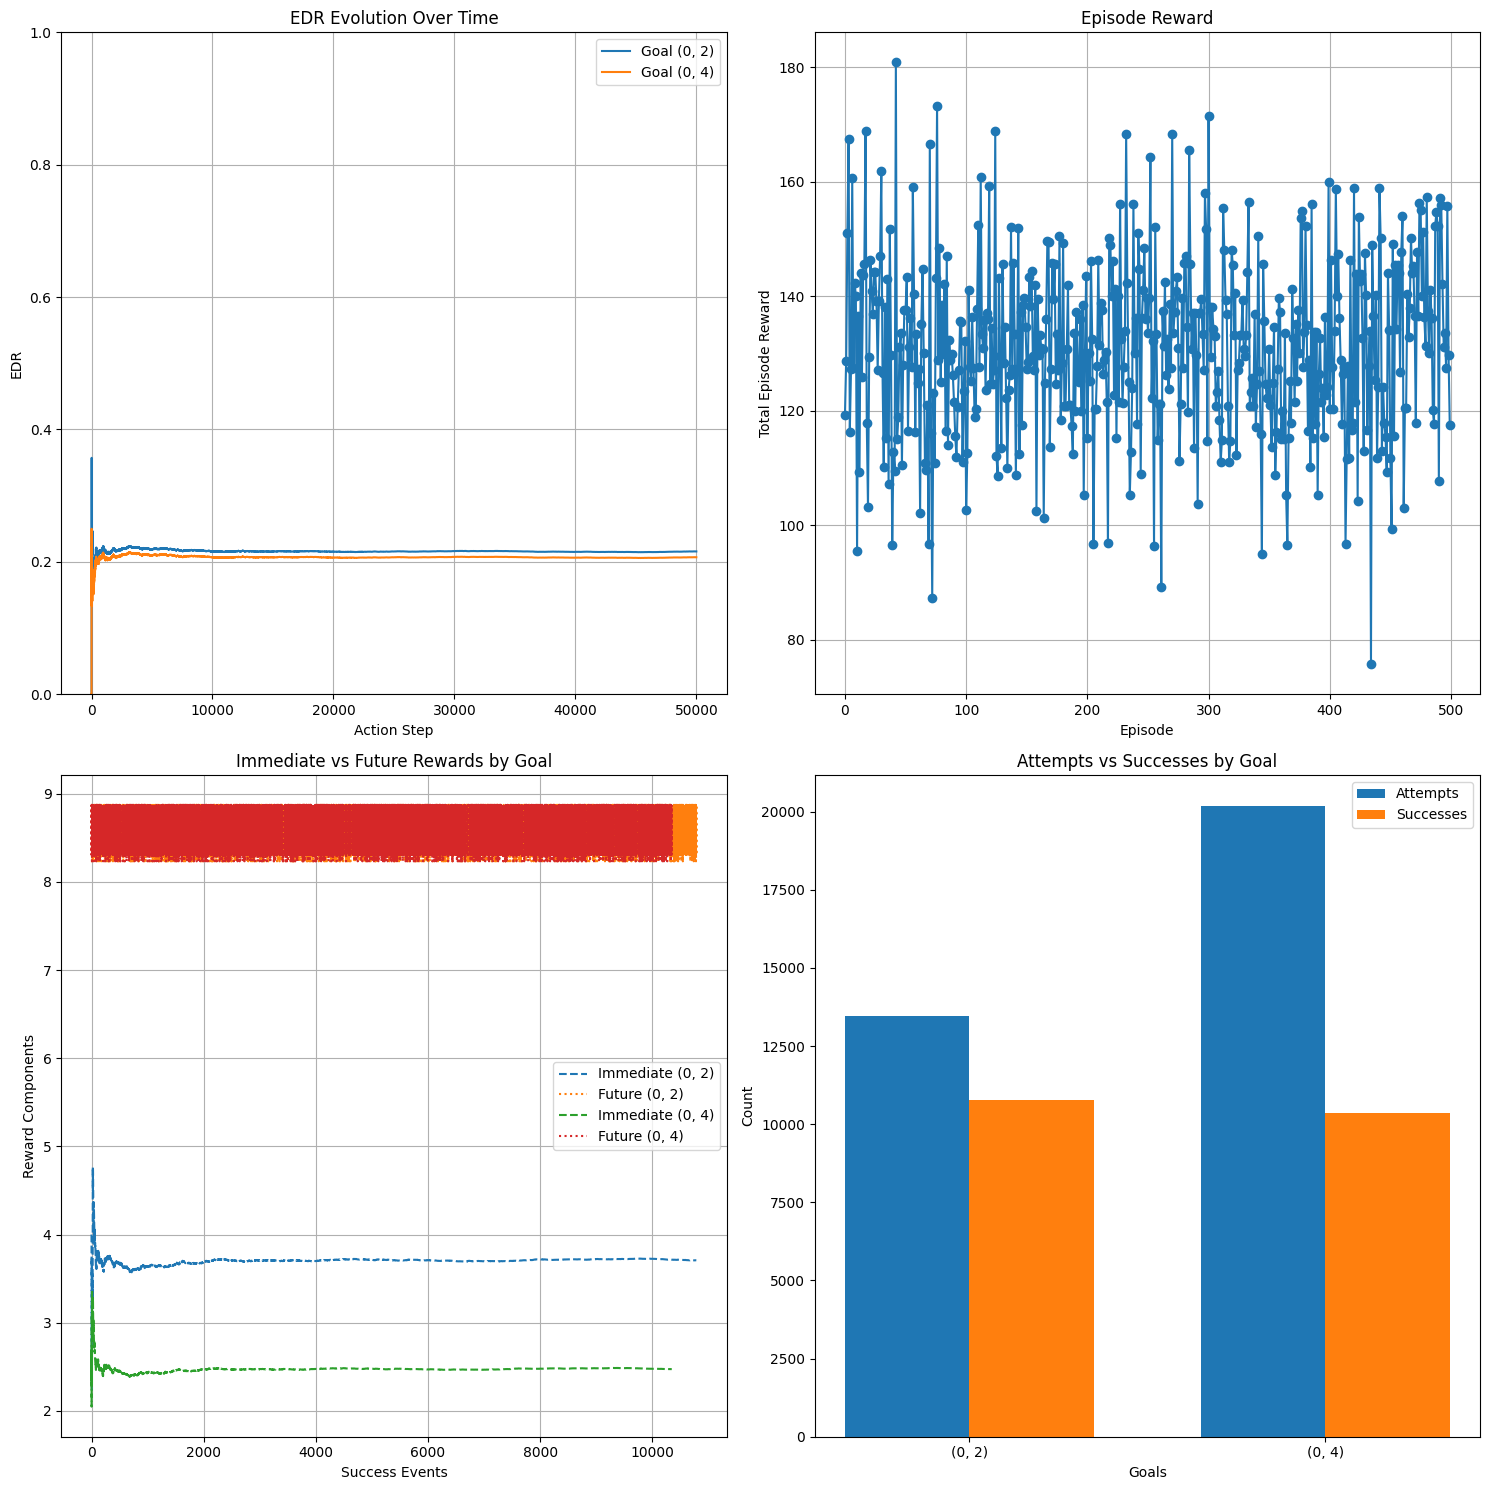

In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Test parameters
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goalEdges = [(0, 2), (0, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 2

# Value iteration parameters
gamma = 0.95
epsilon = 0.0001
max_iterations = 1000

def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0

    total_reward = 0
    for goal_edge, success in achieved_goals:
        if success:
            start, end = goal_edge
            num_edges = abs(end - start)
            instant_rate = pSwap ** (num_edges - 1)
            edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))
            if instant_rate > 0 and edr > 0:
                total_reward += instant_rate / edr
    return total_reward

def get_attempted_goal(next_state, achieved_goals):
    if achieved_goals is None:
        return None
    
    for goal_edge, success in achieved_goals:
        return goal_edge
    return None

def group_transitions_by_action(all_transitions):
    action_groups = defaultdict(list)
    
    for next_state, prob, achieved_goals in all_transitions:
        if achieved_goals is None:
            action_key = None
        else:
            action_key = tuple(sorted(goal for goal, _ in achieved_goals))
        action_groups[action_key].append((next_state, prob, achieved_goals))
    
    return action_groups

def value_iteration(all_transitions, gamma=0.95, epsilon=0.0001, max_iterations=1000):
    """
    Perform value iteration to find the optimal value function.
    """
    # Initialize value function
    V = {state: 0 for state in all_transitions.keys()}
    
    for iteration in range(max_iterations):
        delta = 0
        V_new = V.copy()
        
        # Update each state
        for state in all_transitions.keys():
            action_groups = group_transitions_by_action(all_transitions[state])
            action_values = []
            
            for action_key, transitions in action_groups.items():
                action_value = 0
                
                # Calculate value for this action
                for next_state, prob, achieved_goals in transitions:
                    # Use a dummy success count of 1 for value iteration
                    immediate_reward = getImmediateReward(achieved_goals, {g: 1 for g in goalEdges}, 1)
                    action_value += prob * (immediate_reward + gamma * V[next_state])
                
                action_values.append(action_value)
            
            # Take the maximum value over all actions
            if action_values:
                V_new[state] = max(action_values)
                delta = max(delta, abs(V_new[state] - V[state]))
        
        V = V_new
        
        # Check convergence
        if delta < epsilon:
            print(f"Value iteration converged after {iteration + 1} iterations")
            break
    
    return V

def choose_best_action(state, all_transitions, values, goal_success_counts, total_timesteps, debug=False):
    best_action_group = None
    best_value = float('-inf')
    
    action_groups = group_transitions_by_action(all_transitions[state])
    
    if debug:
        print("\nCurrent state:", state)
        print(f"Current EDRs: {[(goal, goal_success_counts[goal]/total_timesteps) for goal in goalEdges]}")
        print("\nEvaluating actions:")
    
    for action_key, transitions in action_groups.items():
        expected_value = 0
        
        for next_state, prob, achieved_goals in transitions:
            immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
            future_reward = values.get(next_state, 0)
            
            attempted_goal = get_attempted_goal(next_state, achieved_goals)
            if attempted_goal:
                goal_edr = max(0.0001, goal_success_counts[attempted_goal] / total_timesteps)
                future_reward = future_reward / goal_edr
            
            outcome_value = immediate_reward + future_reward
            expected_value += prob * outcome_value
            
            if debug:
                print(f"  Outcome: {next_state}")
                print(f"    P(s'|s,a): {prob:.4f}")
                print(f"    R(s,a,s'): {immediate_reward:.4f}")
                print(f"    γV(s'): {future_reward:.4f}")
                print(f"    Total: {outcome_value:.4f}")
        
        if expected_value > best_value:
            best_value = expected_value
            best_action_group = transitions
    
    if best_action_group:
        transitions = best_action_group
        probs = [t[1] for t in transitions]
        return random.choices(transitions, weights=probs)[0]
    
    return None

# First run value iteration to get optimal values
initial_state = tuple((edge, -1) for edge in edges)
all_transitions = generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge)
optimal_values = value_iteration(all_transitions, gamma=gamma, epsilon=epsilon, max_iterations=max_iterations)

# Simulation parameters
num_episodes = 500
max_steps_per_episode = 100

# Initialize tracking variables
total_timesteps = 1
goal_success_counts = {goal: 0 for goal in goalEdges}
edr_history = {goal: [] for goal in goalEdges}
reward_history = []
goal_immediate_rewards = {goal: [] for goal in goalEdges}
goal_future_rewards = {goal: [] for goal in goalEdges}
goal_attempts = {goal: 0 for goal in goalEdges}
goal_successes = {goal: 0 for goal in goalEdges}

# Use optimal values from value iteration
values = optimal_values

# Evaluation loop
for episode in range(num_episodes):
    state = initial_state
    episode_reward = 0

    for step in range(max_steps_per_episode):
        transition = choose_best_action(
            state, 
            all_transitions, 
            values,
            goal_success_counts, 
            total_timesteps
        )
        
        next_state, prob, achieved_goals = transition
        total_timesteps += 1

        if achieved_goals is not None:
            for goal_edge, success in achieved_goals:
                goal_attempts[goal_edge] += 1
                if success:
                    goal_success_counts[goal_edge] += 1
                    goal_successes[goal_edge] += 1
                    
                    current_edr = goal_success_counts[goal_edge] / total_timesteps
                    instant_rate = pSwap ** (abs(goal_edge[1] - goal_edge[0]) - 1)
                    goal_reward = instant_rate / max(0.0001, current_edr)
                    goal_immediate_rewards[goal_edge].append(goal_reward)
                    goal_future_rewards[goal_edge].append(values.get(next_state, 0))

        immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
        episode_reward += immediate_reward

        for goal in goalEdges:
            current_edr = goal_success_counts[goal] / total_timesteps
            edr_history[goal].append(current_edr)

        state = next_state

    reward_history.append(episode_reward)

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Plot EDR evolution
for goal, edr_values in edr_history.items():
    ax1.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
ax1.set_xlabel('Action Step')
ax1.set_ylabel('EDR')
ax1.set_title('EDR Evolution Over Time')
ax1.grid(True)
ax1.legend()
ax1.set_ylim(0, 1)

# Plot total reward per episode
ax2.plot(range(len(reward_history)), reward_history, marker='o')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Total Episode Reward')
ax2.set_title('Episode Reward')
ax2.grid(True)

# Plot reward components by goal
for goal in goalEdges:
    if goal_immediate_rewards[goal]:
        ax3.plot(range(len(goal_immediate_rewards[goal])), 
                 goal_immediate_rewards[goal], 
                 label=f'Immediate {goal}', linestyle='--')
        ax3.plot(range(len(goal_future_rewards[goal])), 
                 goal_future_rewards[goal], 
                 label=f'Future {goal}', linestyle=':')
ax3.set_xlabel('Success Events')
ax3.set_ylabel('Reward Components')
ax3.set_title('Immediate vs Future Rewards by Goal')
ax3.grid(True)
ax3.legend()

# Plot attempt/success ratio
goals = list(goalEdges)
attempts = [goal_attempts[g] for g in goals]
successes = [goal_successes[g] for g in goals]
x = range(len(goals))
width = 0.35

ax4.bar(x, attempts, width, label='Attempts')
ax4.bar([i + width for i in x], successes, width, label='Successes')
ax4.set_xlabel('Goals')
ax4.set_ylabel('Count')
ax4.set_title('Attempts vs Successes by Goal')
ax4.set_xticks([i + width/2 for i in x])
ax4.set_xticklabels([str(g) for g in goals])
ax4.legend()

plt.tight_layout()

# Print stats
print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
print(f"Network: edges={edges}, goals={goalEdges}")

print("\n=== Final EDR Statistics ===")
for goal in goalEdges:
    final_edr = goal_success_counts[goal] / total_timesteps
    print(f"Goal {goal}: EDR = {final_edr:.6f}")
    print(f"  - Successes: {goal_success_counts[goal]:.2f}")
    print(f"  - Total timesteps: {total_timesteps:.2f}")
    print(f"  - Attempts: {goal_attempts[goal]}")
    print(f"  - Success rate: {goal_successes[goal]/max(1, goal_attempts[goal]):.4f}")

print(f"\nTotal number of EDR data points: {len(edr_history[goalEdges[0]])}")
print(f"Average Episode Reward: {np.mean(reward_history):.4f}")

### **Evaluate with EDR**


Step 0:
Goal (0, 2): Current EDR = 0.000000
Goal (0, 4): Current EDR = 0.000000

Step 1000:
Goal (0, 2): Current EDR = 0.354291
Goal (0, 4): Current EDR = 0.144711

Step 2000:
Goal (0, 2): Current EDR = 0.338661
Goal (0, 4): Current EDR = 0.138362

Step 3000:
Goal (0, 2): Current EDR = 0.331113
Goal (0, 4): Current EDR = 0.135909

Step 4000:
Goal (0, 2): Current EDR = 0.327086
Goal (0, 4): Current EDR = 0.133933

Step 5000:
Goal (0, 2): Current EDR = 0.327669
Goal (0, 4): Current EDR = 0.134346

Step 6000:
Goal (0, 2): Current EDR = 0.328724
Goal (0, 4): Current EDR = 0.134622

Step 7000:
Goal (0, 2): Current EDR = 0.328478
Goal (0, 4): Current EDR = 0.134390

Step 8000:
Goal (0, 2): Current EDR = 0.326168
Goal (0, 4): Current EDR = 0.133592

Step 9000:
Goal (0, 2): Current EDR = 0.326261
Goal (0, 4): Current EDR = 0.133637


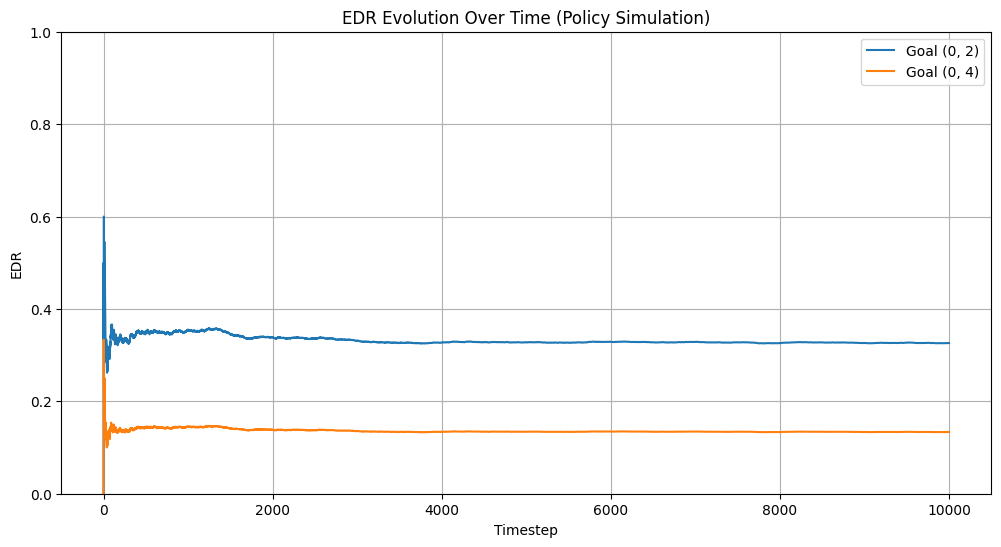


=== Final Statistics ===
Parameters: pSwap=0.8, pGen=0.8, maxAge=2
Network: edges=[(0, 1), (1, 2), (2, 3), (3, 4)], goals=[(0, 2), (0, 4)]

Final EDRs:
Goal (0, 2): EDR = 0.326167
  - Successes: 3262
  - Total timesteps: 10001
Goal (0, 4): EDR = 0.133587
  - Successes: 1336
  - Total timesteps: 10001

Final Episode Reward: 12878.0358


In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import random

def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0

    total_reward = 0
    for goal_edge, success in achieved_goals:
        if success:
            start, end = goal_edge
            num_edges = abs(end - start)
            instant_rate = pSwap ** (num_edges - 1)

            edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))

            if instant_rate > 0 and edr > 0:
                total_reward += instant_rate / edr
    return total_reward

def simulate_policy(edges, goalEdges, values, all_transitions, pSwap, pGen, maxAge, num_steps=4000):
    # Initialize tracking
    total_timesteps = 1
    goal_success_counts = {goal: 0 for goal in goalEdges}
    edr_history = {goal: [] for goal in goalEdges}
    reward_history = []
    
    # Start from initial state
    state = tuple((edge, -1) for edge in edges)
    
    def get_attempted_goal(next_state, achieved_goals):
        if achieved_goals is None:
            return None
        for goal_edge, success in achieved_goals:
            return goal_edge
        return None

    def group_transitions_by_action(transitions):
        action_groups = defaultdict(list)
        for next_state, prob, achieved_goals in transitions:
            if achieved_goals is None:
                action_key = None
            else:
                action_key = tuple(sorted(goal for goal, _ in achieved_goals))
            action_groups[action_key].append((next_state, prob, achieved_goals))
        return action_groups

    def choose_action(state, debug=False):
        best_action_group = None
        best_value = float('-inf')
        
        action_groups = group_transitions_by_action(all_transitions[state])
        
        for action_key, transitions in action_groups.items():
            expected_value = 0
            
            for next_state, prob, achieved_goals in transitions:
                immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
                future_reward = values.get(next_state, 0)
                
                attempted_goal = get_attempted_goal(next_state, achieved_goals)
                if attempted_goal:
                    goal_edr = max(0.0001, goal_success_counts[attempted_goal] / total_timesteps)
                    future_reward = future_reward / goal_edr
                
                outcome_value = immediate_reward + future_reward
                expected_value += prob * outcome_value
            
            if expected_value > best_value:
                best_value = expected_value
                best_action_group = transitions
        
        if best_action_group:
            probs = [t[1] for t in best_action_group]
            return random.choices(best_action_group, weights=probs)[0]
        return None

    # Simulation loop
    episode_reward = 0
    for step in range(num_steps):
        # Choose and execute action
        transition = choose_action(state)
        if transition is None:
            break
            
        next_state, prob, achieved_goals = transition
        
        # Update tracking
        if achieved_goals is not None:
            for goal_edge, success in achieved_goals:
                if success:
                    goal_success_counts[goal_edge] += 1
        
        # Calculate reward
        immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
        episode_reward += immediate_reward
        
        # Update EDR history
        for goal in goalEdges:
            current_edr = goal_success_counts[goal] / total_timesteps
            edr_history[goal].append(current_edr)
        
        # Progress to next state
        state = next_state
        total_timesteps += 1
        
        # Print progress
        if step % 1000 == 0:
            print(f"\nStep {step}:")
            for goal in goalEdges:
                current_edr = goal_success_counts[goal] / total_timesteps
                print(f"Goal {goal}: Current EDR = {current_edr:.6f}")
    
    reward_history.append(episode_reward)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    for goal, edr_values in edr_history.items():
        ax.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('EDR')
    ax.set_title('EDR Evolution Over Time (Policy Simulation)')
    ax.grid(True)
    ax.legend()
    ax.set_ylim(0, 1)
    plt.show()
    
    # Print statistics
    print(f"\n=== Final Statistics ===")
    print(f"Parameters: pSwap={pSwap}, pGen={pGen}, maxAge={maxAge}")
    print(f"Network: edges={edges}, goals={goalEdges}")
    print("\nFinal EDRs:")
    for goal in goalEdges:
        final_edr = goal_success_counts[goal] / total_timesteps
        print(f"Goal {goal}: EDR = {final_edr:.6f}")
        print(f"  - Successes: {goal_success_counts[goal]}")
        print(f"  - Total timesteps: {total_timesteps}")
    
    print(f"\nFinal Episode Reward: {episode_reward:.4f}")
    
    return edr_history, goal_success_counts, total_timesteps

# Example usage
edr_history, goals_achieved, total_timesteps = simulate_policy(
    edges=edges,
    goalEdges=goalEdges,
    values=values,  # Your converged value function
    all_transitions=all_transitions,  # Your transition function
    pSwap=pSwap,
    pGen=pGen,
    maxAge=maxAge,
    num_steps=10000
)